In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,  array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
PARENT_DATA_DIR ='/content/drive/MyDrive/Website-2/Dataset_patches'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Training')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Validation')

IMG_SIZE = 96
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

classes = len(CATEGORIES)
classes

['Normal', 'Foot_Ulcer']


2

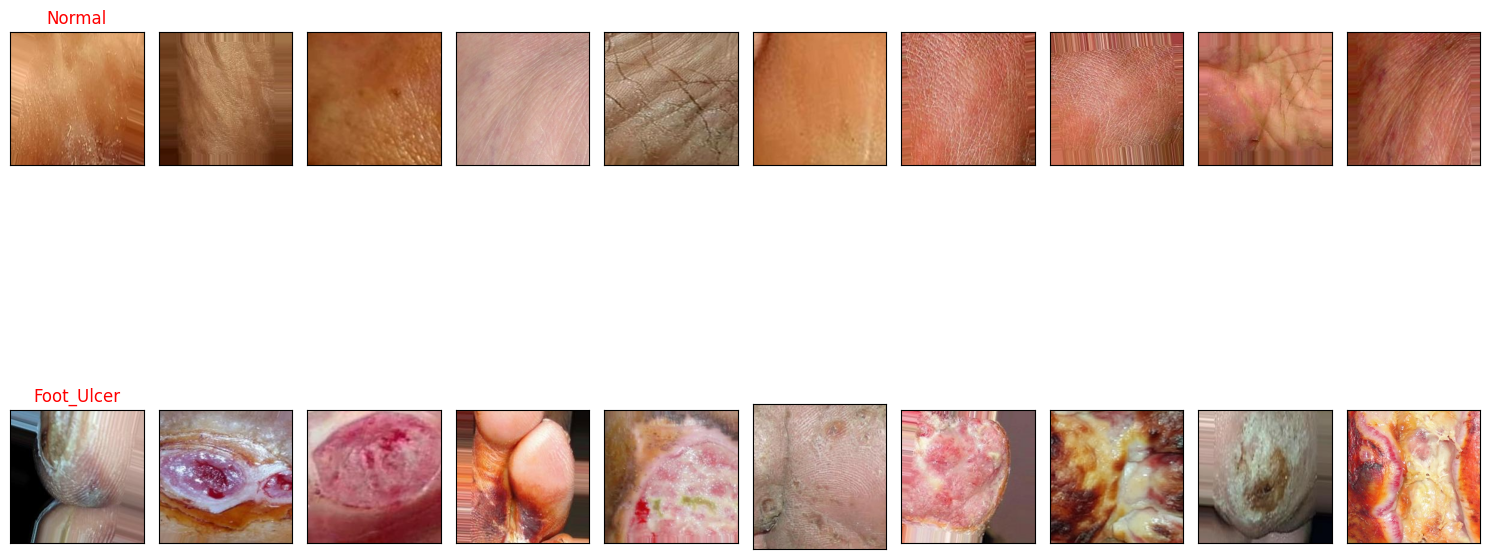

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

100%|██████████| 1200/1200 [00:26<00:00, 45.33it/s] 


2400


100%|██████████| 300/300 [00:05<00:00, 53.58it/s] 


600
X_train= (2400, 96, 96, 3) Y_train= (2400,)
X_test= (600, 96, 96, 3) Y_test= (600,)


In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Number of classes (adjust this based on your DFU dataset)
num_classes = len(CATEGORIES)

# Load DenseNet121 model, excluding the top (output) layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling instead of flattening
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Final classification layer

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of DenseNet121 to prevent them from being trained initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

# Unfreeze all layers for fine-tuning after initial training
for layer in base_model.layers:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 102, 102, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 24, 24, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 24, 24, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 24, 24, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,563,330 (28.85 MB)

 Trainable params: 525,826 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.7829 - loss: 0.5230 - val_accuracy: 0.9617 - val_loss: 0.1018
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9570 - loss: 0.1286 - val_accuracy: 0.9667 - val_loss: 0.0851
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9773 - loss: 0.0762 - val_accuracy: 0.9700 - val_loss: 0.0884
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9793 - loss: 0.0669 - val_accuracy: 0.9767 - val_loss: 0.0875
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9826 - loss: 0.0504 - val_accuracy: 0.9817 - val_loss: 0.0750
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9836 - loss: 0.0516 - val_accuracy: 0.9833 - val_loss: 0.0702
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9893 - loss: 0.0337 - val_accuracy: 0.9833 - val_loss: 0.0704
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9916 - loss: 0.0287 - val_accuracy: 0.9833 -

In [7]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
Y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded format to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate classification report
print(classification_report(Y_test, Y_pred_classes, target_names=CATEGORIES))


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99       300
  Foot_Ulcer       1.00      0.97      0.98       300

    accuracy                           0.98       600
   macro avg       0.99      0.99      0.98       600
weighted avg       0.99      0.98      0.98       600



# GradCam

In [9]:
print(CATEGORIES)

['Normal', 'Foot_Ulcer']


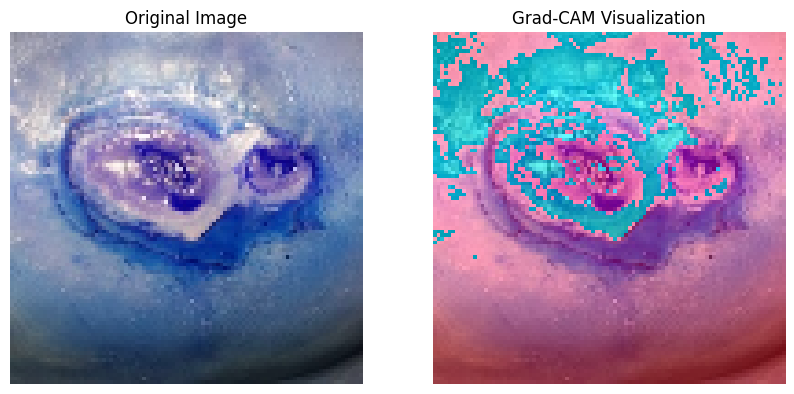

In [30]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
import tensorflow as tf

def get_gradcam_heatmap(model, img_array, layer_name):
    # Ensure the image array is a batch
    img_array = np.expand_dims(img_array, axis=0)

    # Create a model that maps the input image to the activations of the target layer
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    # Get the gradients of the top predicted class w.r.t the output feature map of the target layer
    grads = tape.gradient(top_class_channel, conv_outputs)[0]

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map with the guided gradients
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads

    # Average over all the channels to obtain the heatmap
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap  # It's already a numpy array


def display_gradcam(img, heatmap, alpha=0.9, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match the original image size (no resizing)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # Apply a colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + img

    # Plot the original image and Grad-CAM superimposed image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title("Grad-CAM Visualization")
    plt.axis('off')
    plt.show()

# Select a random ulcer image
ulcer_images = [img for img, label in test_data if label == CATEGORIES.index('Foot_Ulcer')]
random_img = random.choice(ulcer_images)

# Preprocess the image for the model
img = random_img / 255.0  # Normalization
img_array = img_to_array(img)

# Apply Grad-CAM
layer_name = 'conv5_block16_concat'  # Adjust based on the final convolutional layer in your DenseNet model
heatmap = get_gradcam_heatmap(model, img_array, layer_name)

# Visualize the Grad-CAM heatmap without zooming
display_gradcam(random_img, heatmap, alpha=0.8, colormap=cv2.COLORMAP_JET)
